In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

sns.set_style("whitegrid")

In [2]:
PATH_ROOT=Path("../").resolve()
PATH_ROOT

PosixPath('/home/yparomau/Projects/superconduct-tc-reg')

## KMeans

### Without dimensionality reduction

In [3]:
df_scaled = pd.read_csv(PATH_ROOT/"data/processed/train-minmax-no_cfs-no_pca.csv")
with pd.option_context('display.max_columns', 82):
    display(df_scaled)

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   0.375          0.405879              0.253950   
1                   0.500          0.424611              0.257187   
2                   0.375          0.405879              0.254061   
3                   0.375          0.405879              0.254005   
4                   0.375          0.405879              0.253838   
...                   ...               ...                   ...   
21258               0.375          0.495037              0.230416   
21259               0.500          0.422322              0.210301   
21260               0.125          0.458931              0.440299   
21261               0.125          0.458931              0.447638   
21262               0.250          0.398572              0.397098   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0               0.299720               0.164988             0.595724   
1               0.332968               0.166341             0.730573   
2               0.299720               0.165017             0.595724   
3               0.299720               0.165002             0.595724   
4               0.299720               0.164960             0.595724   
...                  ...                    ...                  ...   
21258           0.379038               0.198893             0.593380   
21259           0.292115               0.149295             0.667047   
21260           0.462110               0.451665             0.348245   
21261           0.462110               0.458605             0.348245   
21262           0.379236               0.379181             0.524887   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                     0.542536           0.590973               0.154652   
1                     0.540166           0.590973               0.175894   
2                     0.498406           0.590973               0.173847   
3                     0.522056           0.590973               0.164249   
4                     0.576663           0.590973               0.135458   
...                        ...                ...                    ...   
21258                 0.640444           0.706254               0.075415   
21259                 0.802588           0.905812               0.035767   
21260                 0.270757           0.064978               0.257995   
21261                 0.327281           0.064978               0.151346   
21262                 0.457169           0.345022               0.209855   

       std_atomic_mass  wtd_std_atomic_mass  mean_fie  wtd_mean_fie  \
0             0.514443             0.530813  0.426541      0.652699   
1             0.466193             0.534350  0.416958      0.653053   
2             0.514443             0.531147  0.426541      0.653266   
3             0.514443             0.530980  0.426541      0.652982   
4             0.514443             0.530478  0.426541      0.652132   
...                ...                  ...       ...           ...   
21258         0.651003             0.427666  0.305327      0.388979   
21259         0.685338             0.496421  0.397056      0.631672   
21260         0.066886             0.053509  0.381879      0.325008   
21261         0.066886             0.061869  0.381879      0.340832   
21262         0.296034             0.335855  0.512656      0.458279   

       gmean_fie  wtd_gmean_fie  entropy_fie  wtd_entropy_fie  range_fie  \
0       0.365457       0.590821     0.605237         0.388258   0.621388   
1       0.368073       0.591586     0.715618         0.395906   0.621388   
2       0.365457       0.591863     0.605237         0.379493   0.621388   
3       0.365457       0.591342     0.605237         0.384196   0.621388   
4       0.365457       0.589780     0.605237         0.394999   0.621388   
...          ...            ...          ...              ...        ...   
21258   0.29448

In [4]:
feature_columns = df_scaled.drop("critical_temp", axis=1).columns
feature_columns

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

def cluster_number_analysis(df, features, range_n_clusters, features_to_plot):

    silhouette_avg_scores = []
    inertia = []

    fig, axs = plt.subplots(nrows=len(range_n_clusters), ncols=2, figsize=(12, 5*len(range_n_clusters)))

    for n_clusters, axs_row in zip(range_n_clusters, axs):
        axs_row[0].set_xlabel("silhouette score")
        
        colors = sns.color_palette(n_colors=n_clusters)

        model = KMeans(n_clusters=n_clusters)
        clusterer = SilhouetteVisualizer(model, ax=axs_row[0], colors=colors)
        clusterer.fit(df[features])

        color_map = dict(zip(range(n_clusters), colors))
        cluster_labels = model.predict(df[features]).astype(int)
        sns.scatterplot(
            df, 
            x=features_to_plot[0], 
            y=features_to_plot[1], 
            hue=cluster_labels,
            palette=color_map,
            ax=axs_row[1],
            size="critical_temp",
            size_norm=(0, 273.15)
        )
        axs_row[1].set_ylabel(features_to_plot[1])
        axs_row[1].set_xlabel(features_to_plot[0])
        
        axs_row[1].get_legend().set_visible(False)

        inertia.append(model.inertia_)
        silhouette_avg_scores.append(clusterer.silhouette_score_)

    fig.tight_layout()
    fig.show()
    
    plt.figure()
    plt.plot(range_n_clusters, silhouette_avg_scores)
    plt.xlabel("n clusters")
    plt.ylabel("mean silhouette score")
    plt.show()

    plt.plot(range_n_clusters, inertia)
    plt.xlabel("n clusters")
    plt.ylabel("inertia")
    plt.show()

/tmp/ipykernel_2986354/1228126881.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


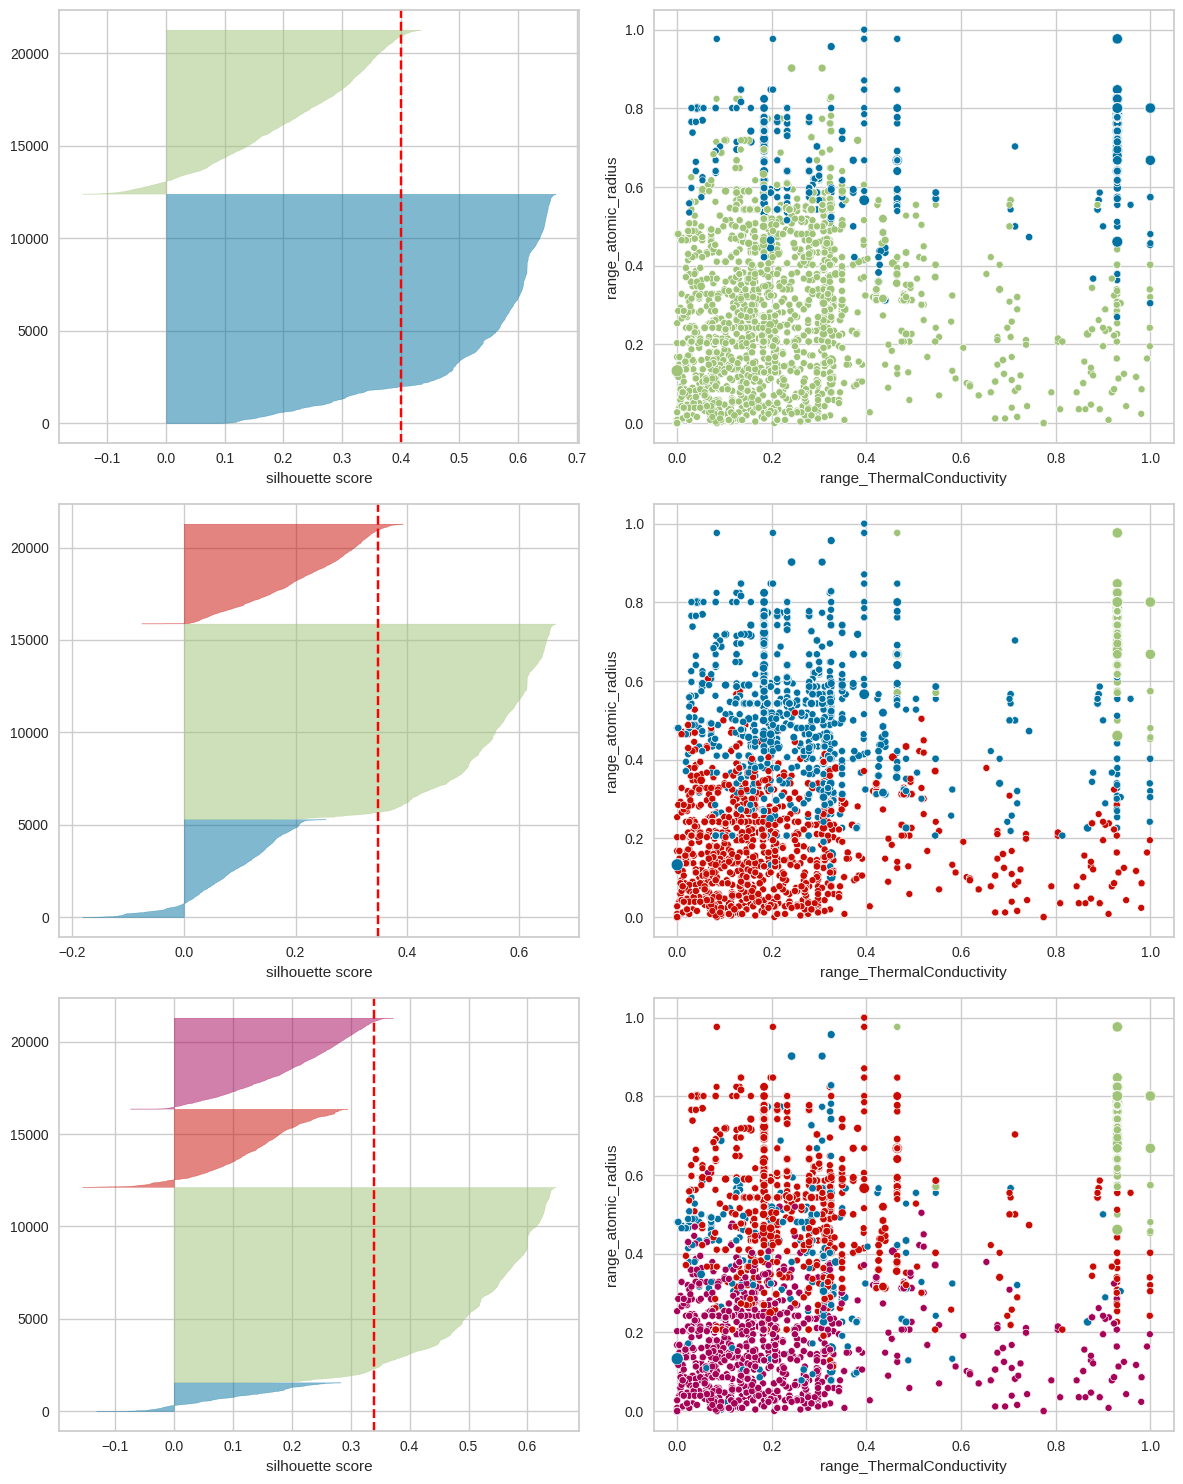

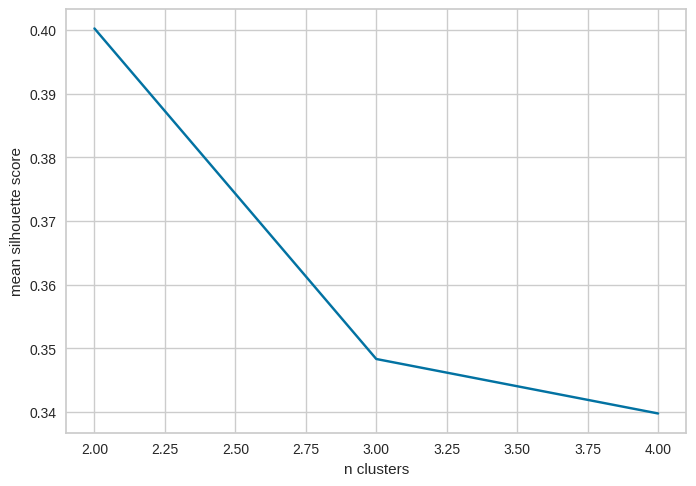

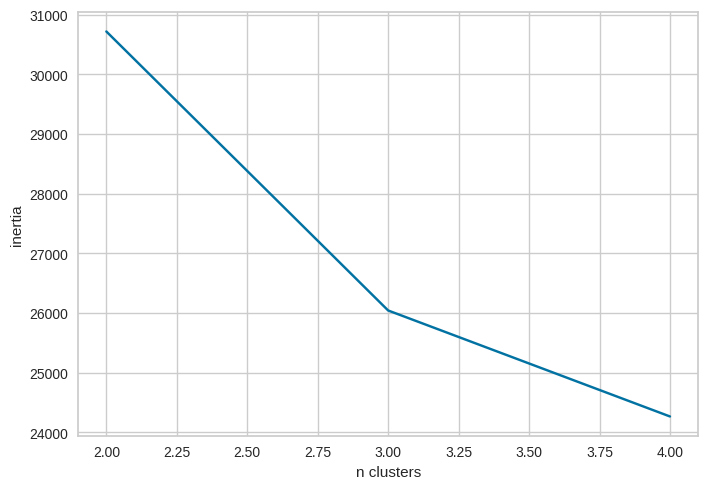

In [24]:
cluster_number_analysis(
    df=df_scaled,
    features=feature_columns,
    range_n_clusters=[2, 3, 4],
    features_to_plot = ["range_ThermalConductivity", "range_atomic_radius"]
)


### With reduction using PCA

In [16]:
df_pca = pd.read_csv(PATH_ROOT / "data/processed/train-minmax-no_cfs-pca.csv")
df_pca

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0     -0.760072  0.632861 -0.005633  0.205954 -0.061266  0.009457 -0.056623   
1     -0.954494  0.323756 -0.140948  0.014345  0.055140 -0.160309 -0.138492   
2     -0.725584  0.658725 -0.002053  0.225602 -0.054429  0.001070 -0.062875   
3     -0.743881  0.644796 -0.004184  0.215193 -0.058017  0.005267 -0.059692   
4     -0.787915  0.613294 -0.007108  0.189978 -0.067076  0.017842 -0.050732   
...         ...       ...       ...       ...       ...       ...       ...   
21258  0.458121 -0.366652  0.066112 -0.172551  0.454688  0.078101 -0.335912   
21259 -1.102695  0.132710 -0.137091  0.037698  0.130095  0.195354 -0.180732   
21260  1.996372  0.184068 -0.168859 -0.252544 -0.084022 -0.138223 -0.168591   
21261  1.898402  0.085539 -0.155516 -0.321927 -0.143109 -0.001373 -0.048430   
21262  1.049020 -0.215873  0.042090  0.038452 -0.515463 -0.375628  0.386727   

           pc_7      pc_8      pc_9  ...     pc_72     pc_73     pc_74  \
0     -0.050663  0.035798 -0.051830  ... -0.000273  0.000234 -0.000267   
1      0.154380 -0.031449  0.058003  ... -0.004173 -0.001792  0.001627   
2     -0.017677  0.069609 -0.045809  ... -0.001514  0.000066 -0.000112   
3     -0.034942  0.051925 -0.048898  ... -0.000832  0.000144 -0.000222   
4     -0.078792  0.006858 -0.057322  ...  0.000582  0.000425 -0.000213   
...         ...       ...       ...  ...       ...       ...       ...   
21258 -0.163454 -0.009760 -0.028998  ... -0.002973 -0.000280 -0.003667   
21259 -0.072055 -0.127050  0.221592  ... -0.004185  0.000463 -0.002399   
21260 -0.062990  0.103902  0.064411  ... -0.004269 -0.001601  0.001318   
21261 -0.218298 -0.054538  0.036676  ... -0.003125 -0.000754  0.000911   
21262 -0.112589 -0.164905 -0.147525  ...  0.007309 -0.003889 -0.000257   

          pc_75     pc_76     pc_77     pc_78     pc_79     pc_80  \
0     -0.000790 -0.000918  0.000206  0.001071 -0.000497 -0.000654   
1     -0.003312 -0.001039  0.001707  0.000318 -0.000950 -0.000724   
2     -0.000278 -0.000531 -0.000062  0.000946 -0.000780 -0.000735   
3     -0.000558 -0.000739  0.000082  0.001022 -0.000627 -0.000692   
4     -0.001141 -0.001208  0.000408  0.001117 -0.000281 -0.000589   
...         ...       ...       ...       ...       ...       ...   
21258 -0.006852 -0.002239 -0.002947 -0.000601  0.004516 -0.001295   
21259  0.002788 -0.000126 -0.000738 -0.000203  0.000877 -0.000086   
21260  0.000591 -0.000906  0.001942  0.001442  0.000461 -0.000004   
21261  0.000178 -0.000696  0.001149  0.001564 -0.000636  0.000186   
21262  0.002641 -0.001906  0.000342 -0.000327  0.000585  0.000428   

       critical_temp  
0              29.00  
1              26.00  
2              19.00  
3              22.00  
4              23.00  
...              ...  
21258           2.44  
21259         122.10  
21260           1.98  
21261           1.84  
21262          12.80  

[21263 rows x 82 columns]

/tmp/ipykernel_2986354/1228126881.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


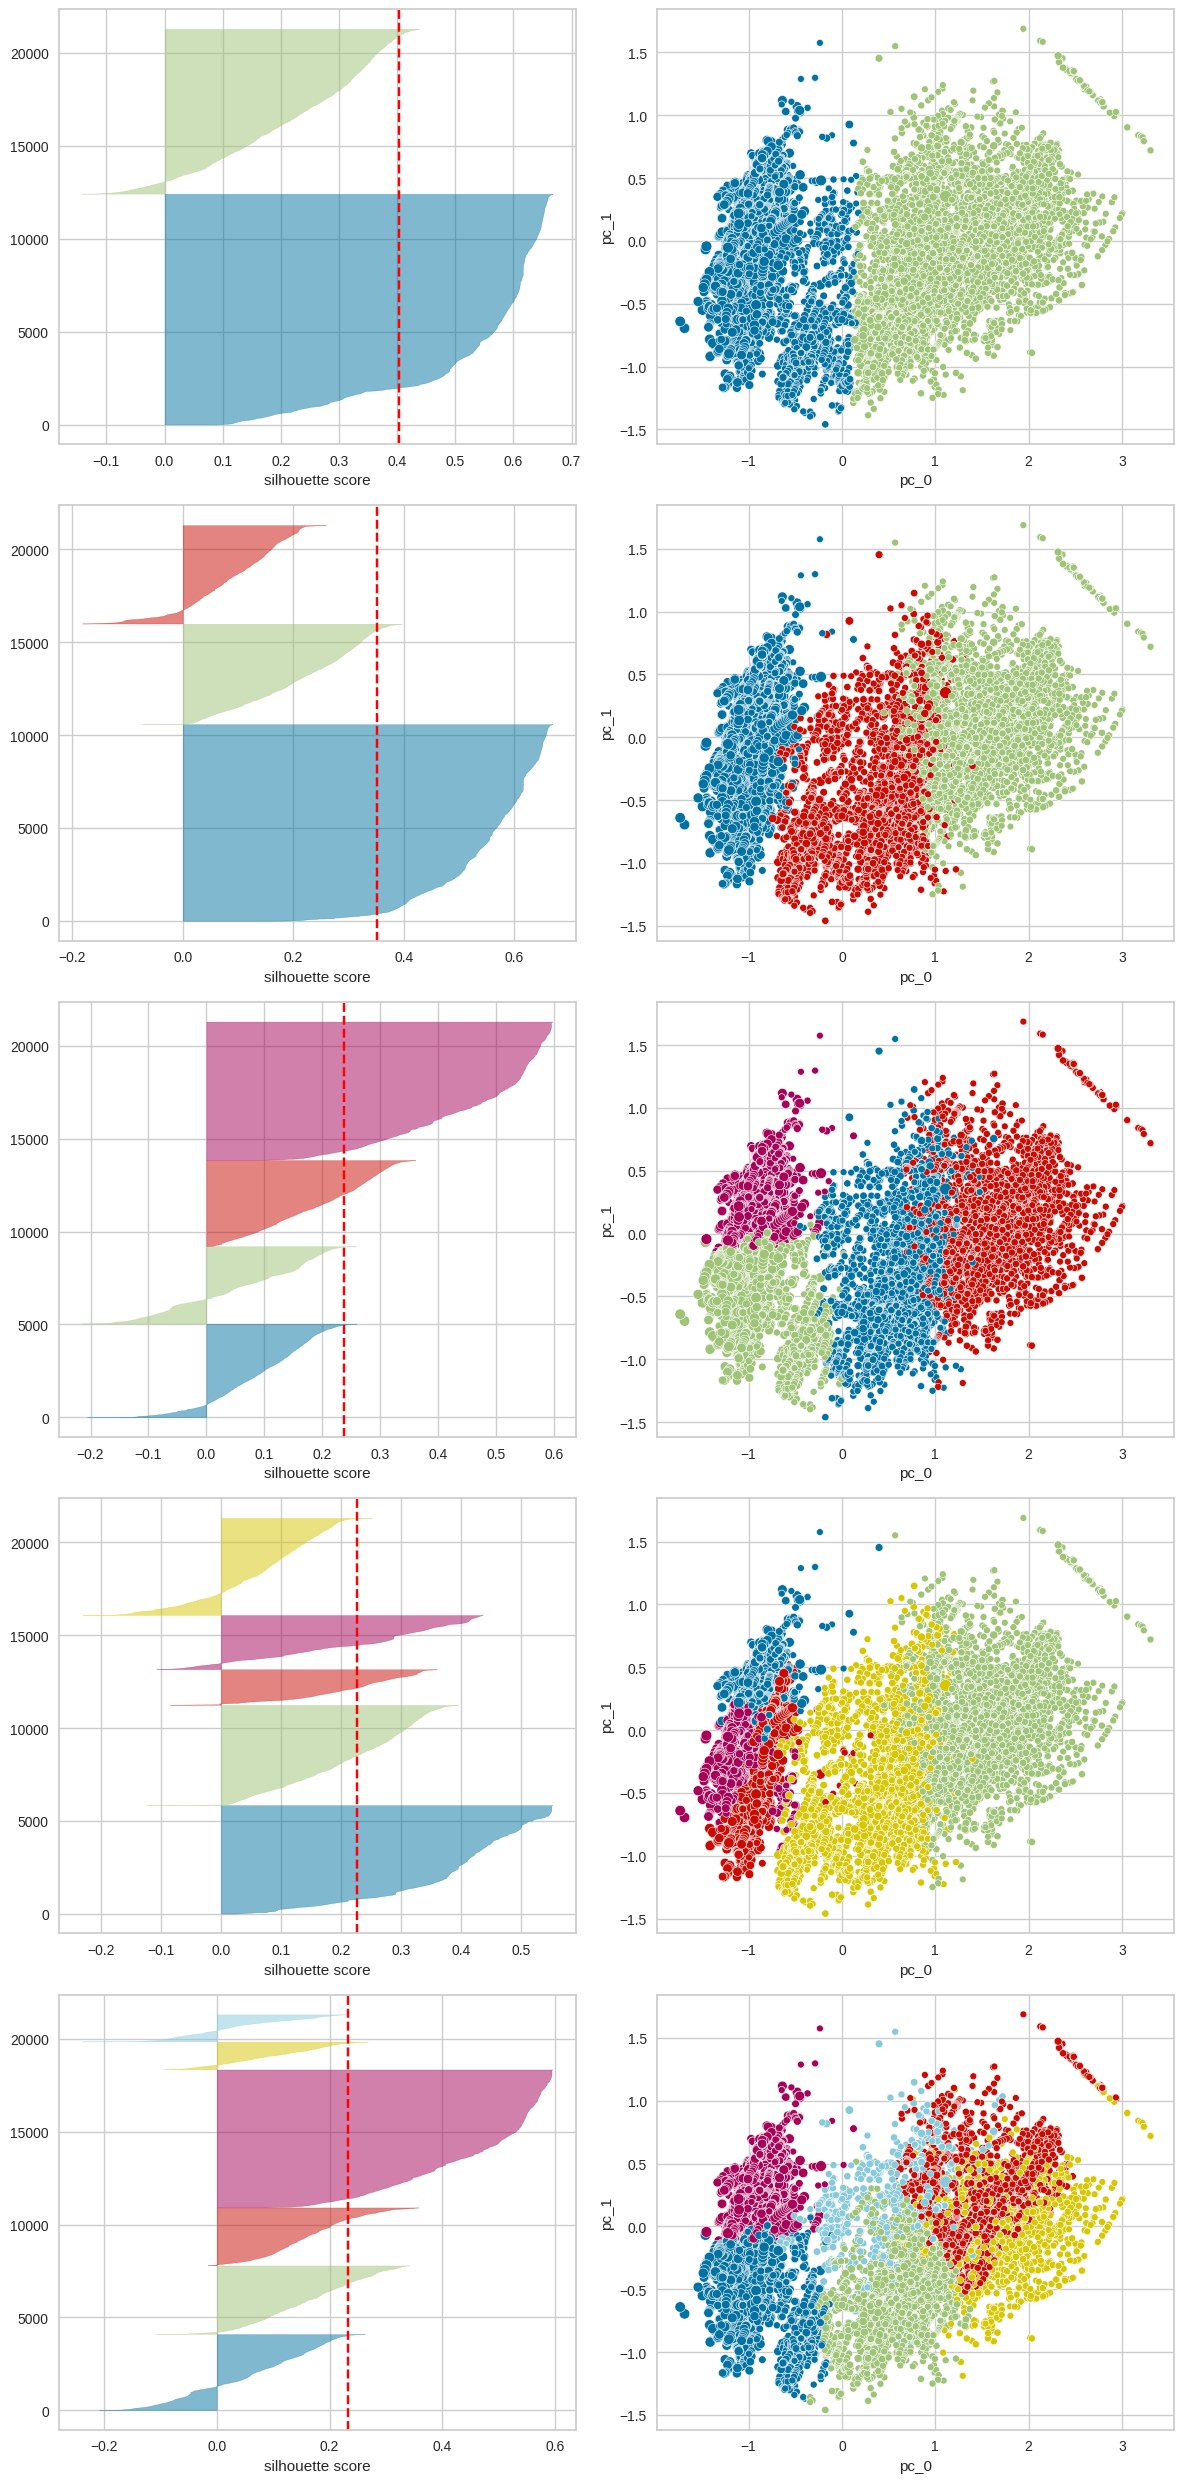

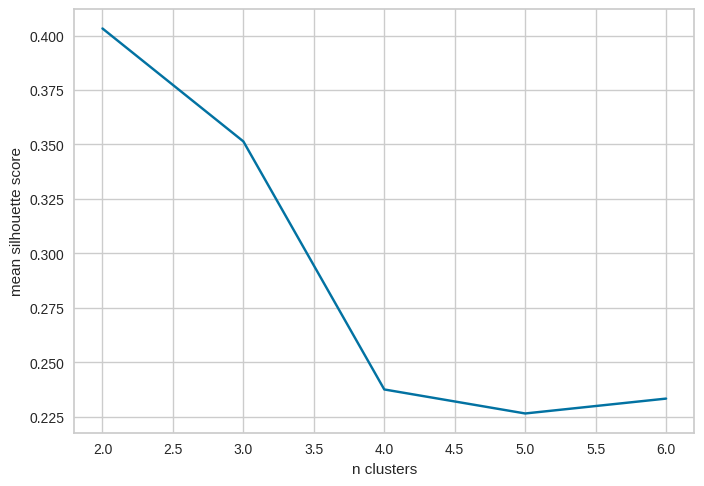

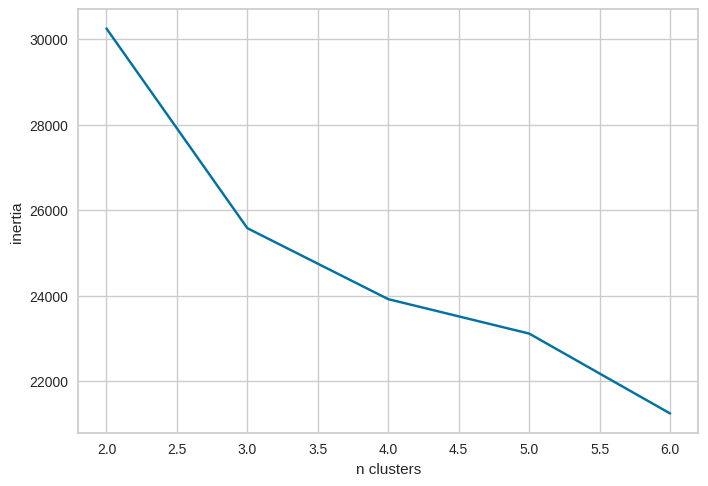

In [25]:
n_components = 30
cluster_number_analysis(df=df_pca, features=[f"pc_{i}" for i in range(n_components)], range_n_clusters=[2, 3, 4, 5, 6], features_to_plot=["pc_0", "pc_1"])

/tmp/ipykernel_2986354/1228126881.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


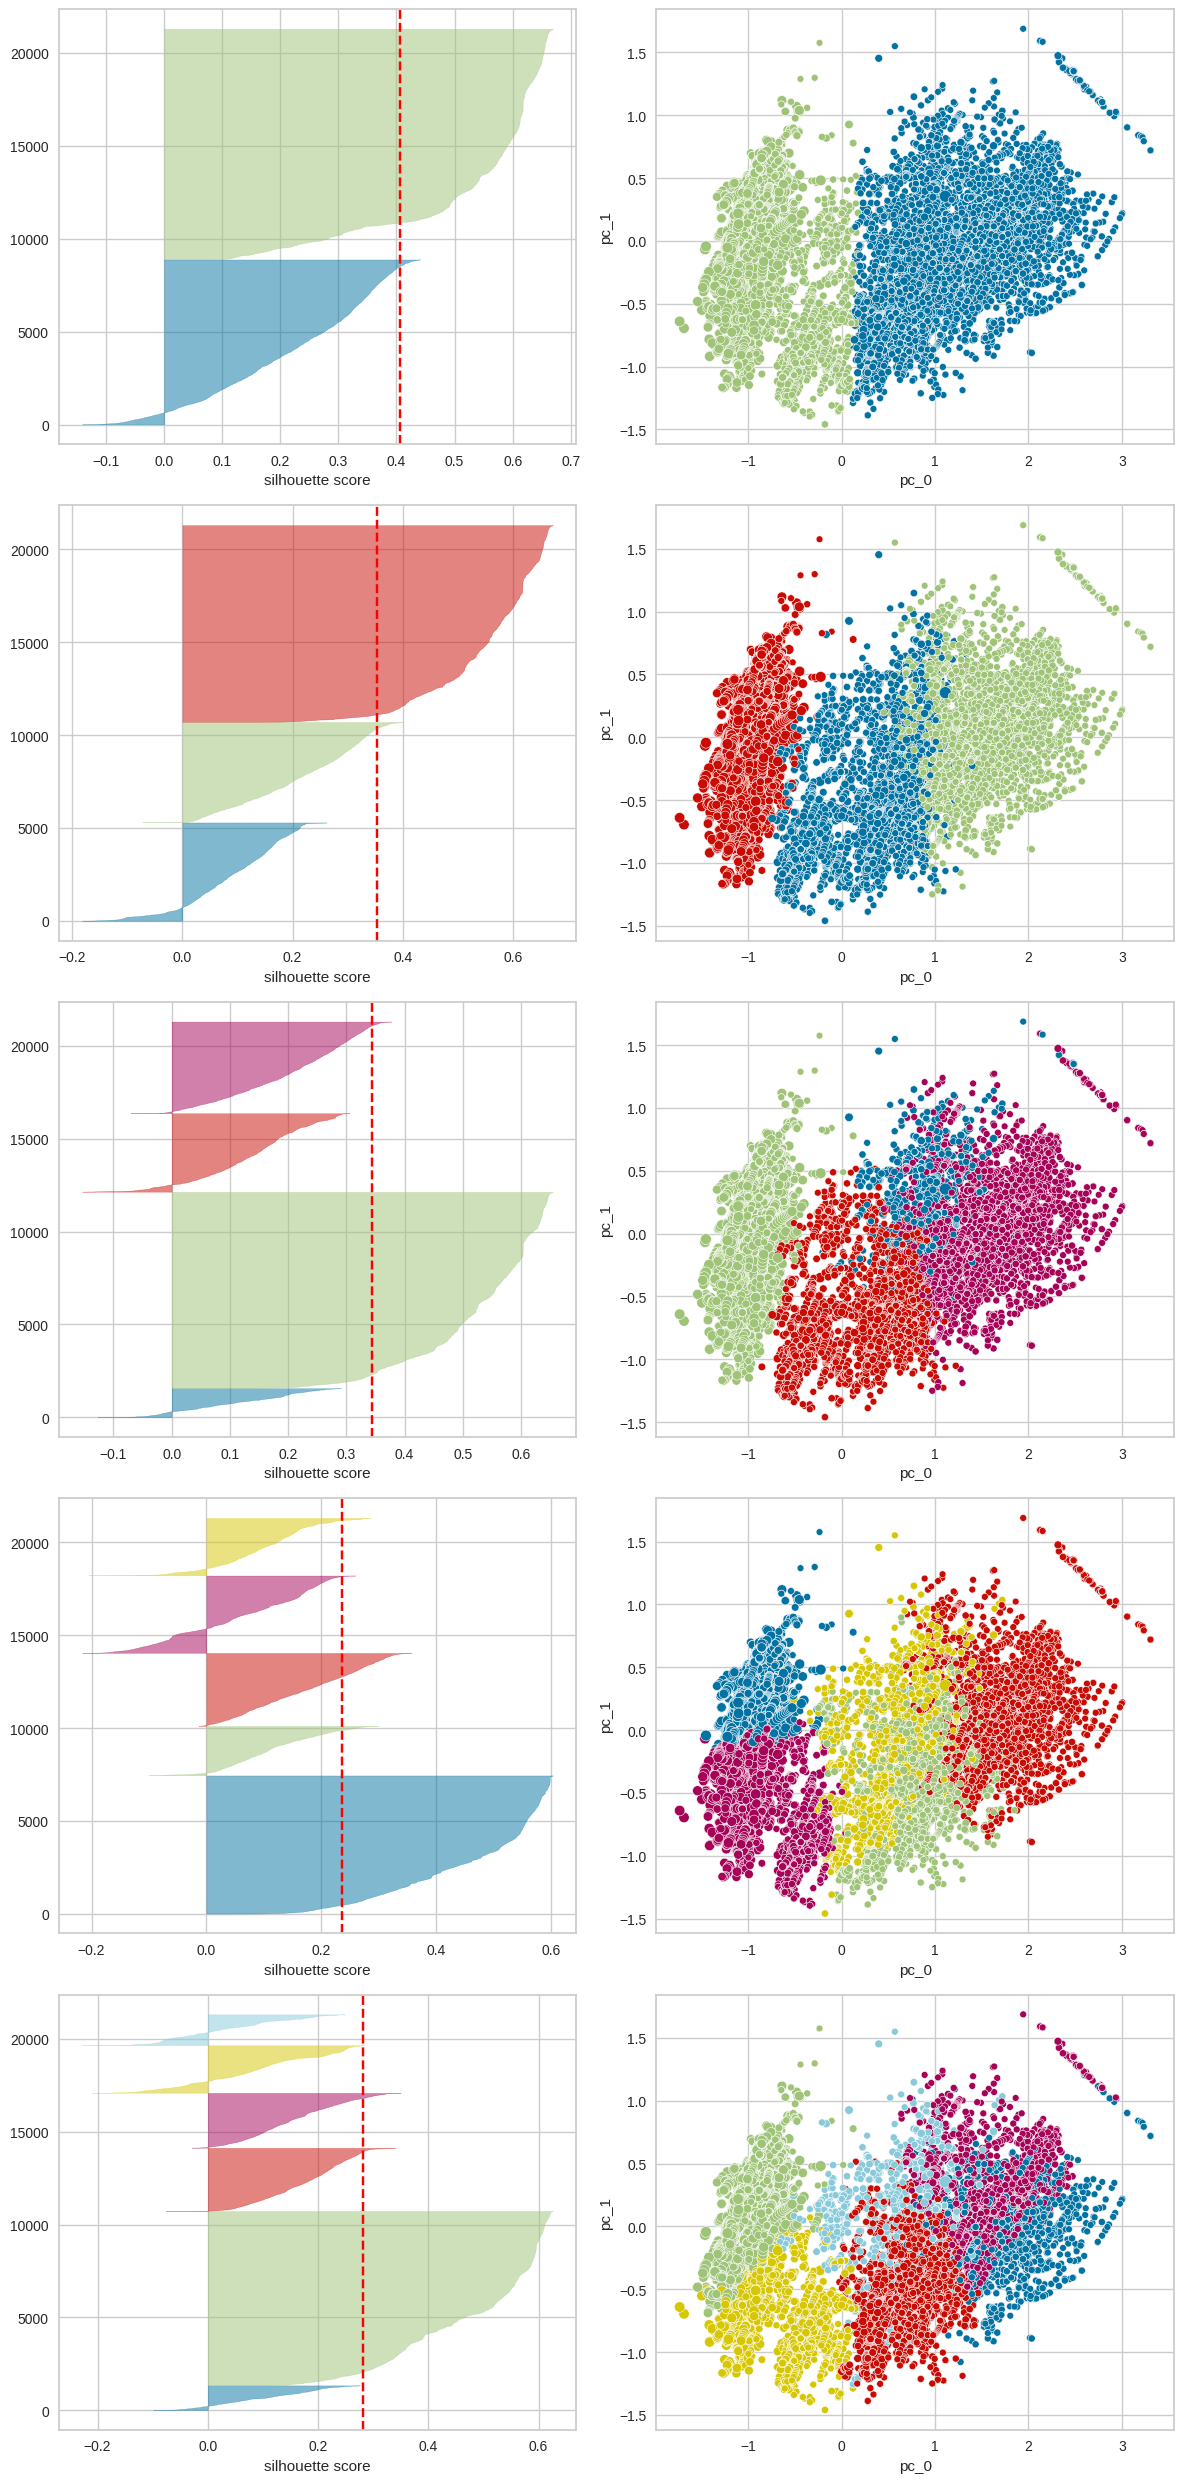

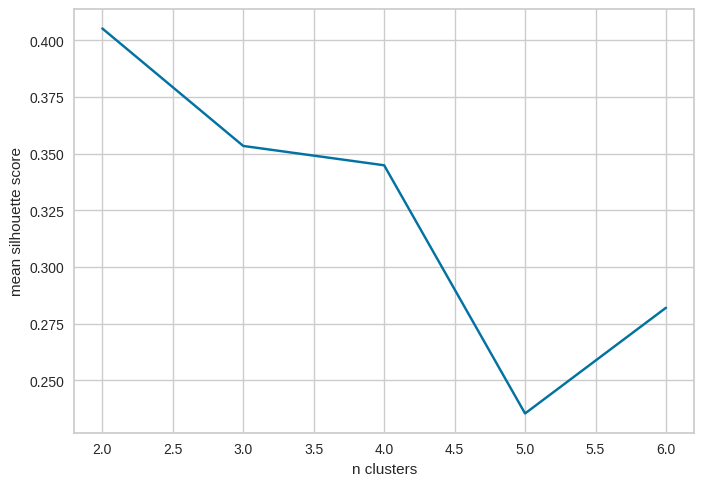

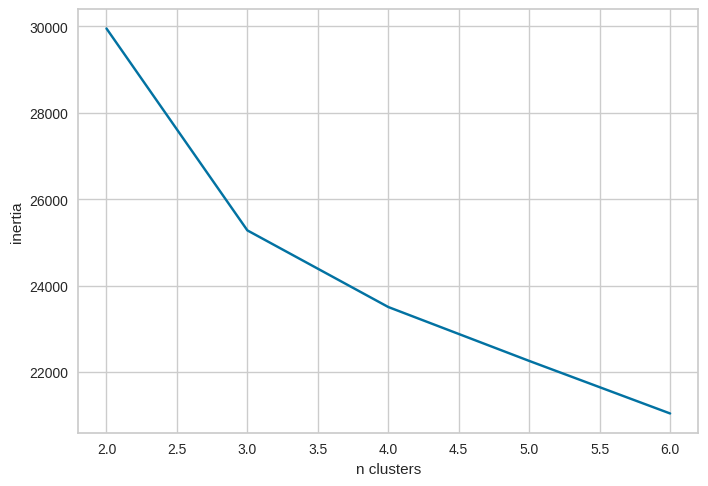

In [26]:
n_components = 25
cluster_number_analysis(df=df_pca, features=[f"pc_{i}" for i in range(n_components)], range_n_clusters=[2, 3, 4, 5, 6], features_to_plot=["pc_0", "pc_1"])

/tmp/ipykernel_2986354/1228126881.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


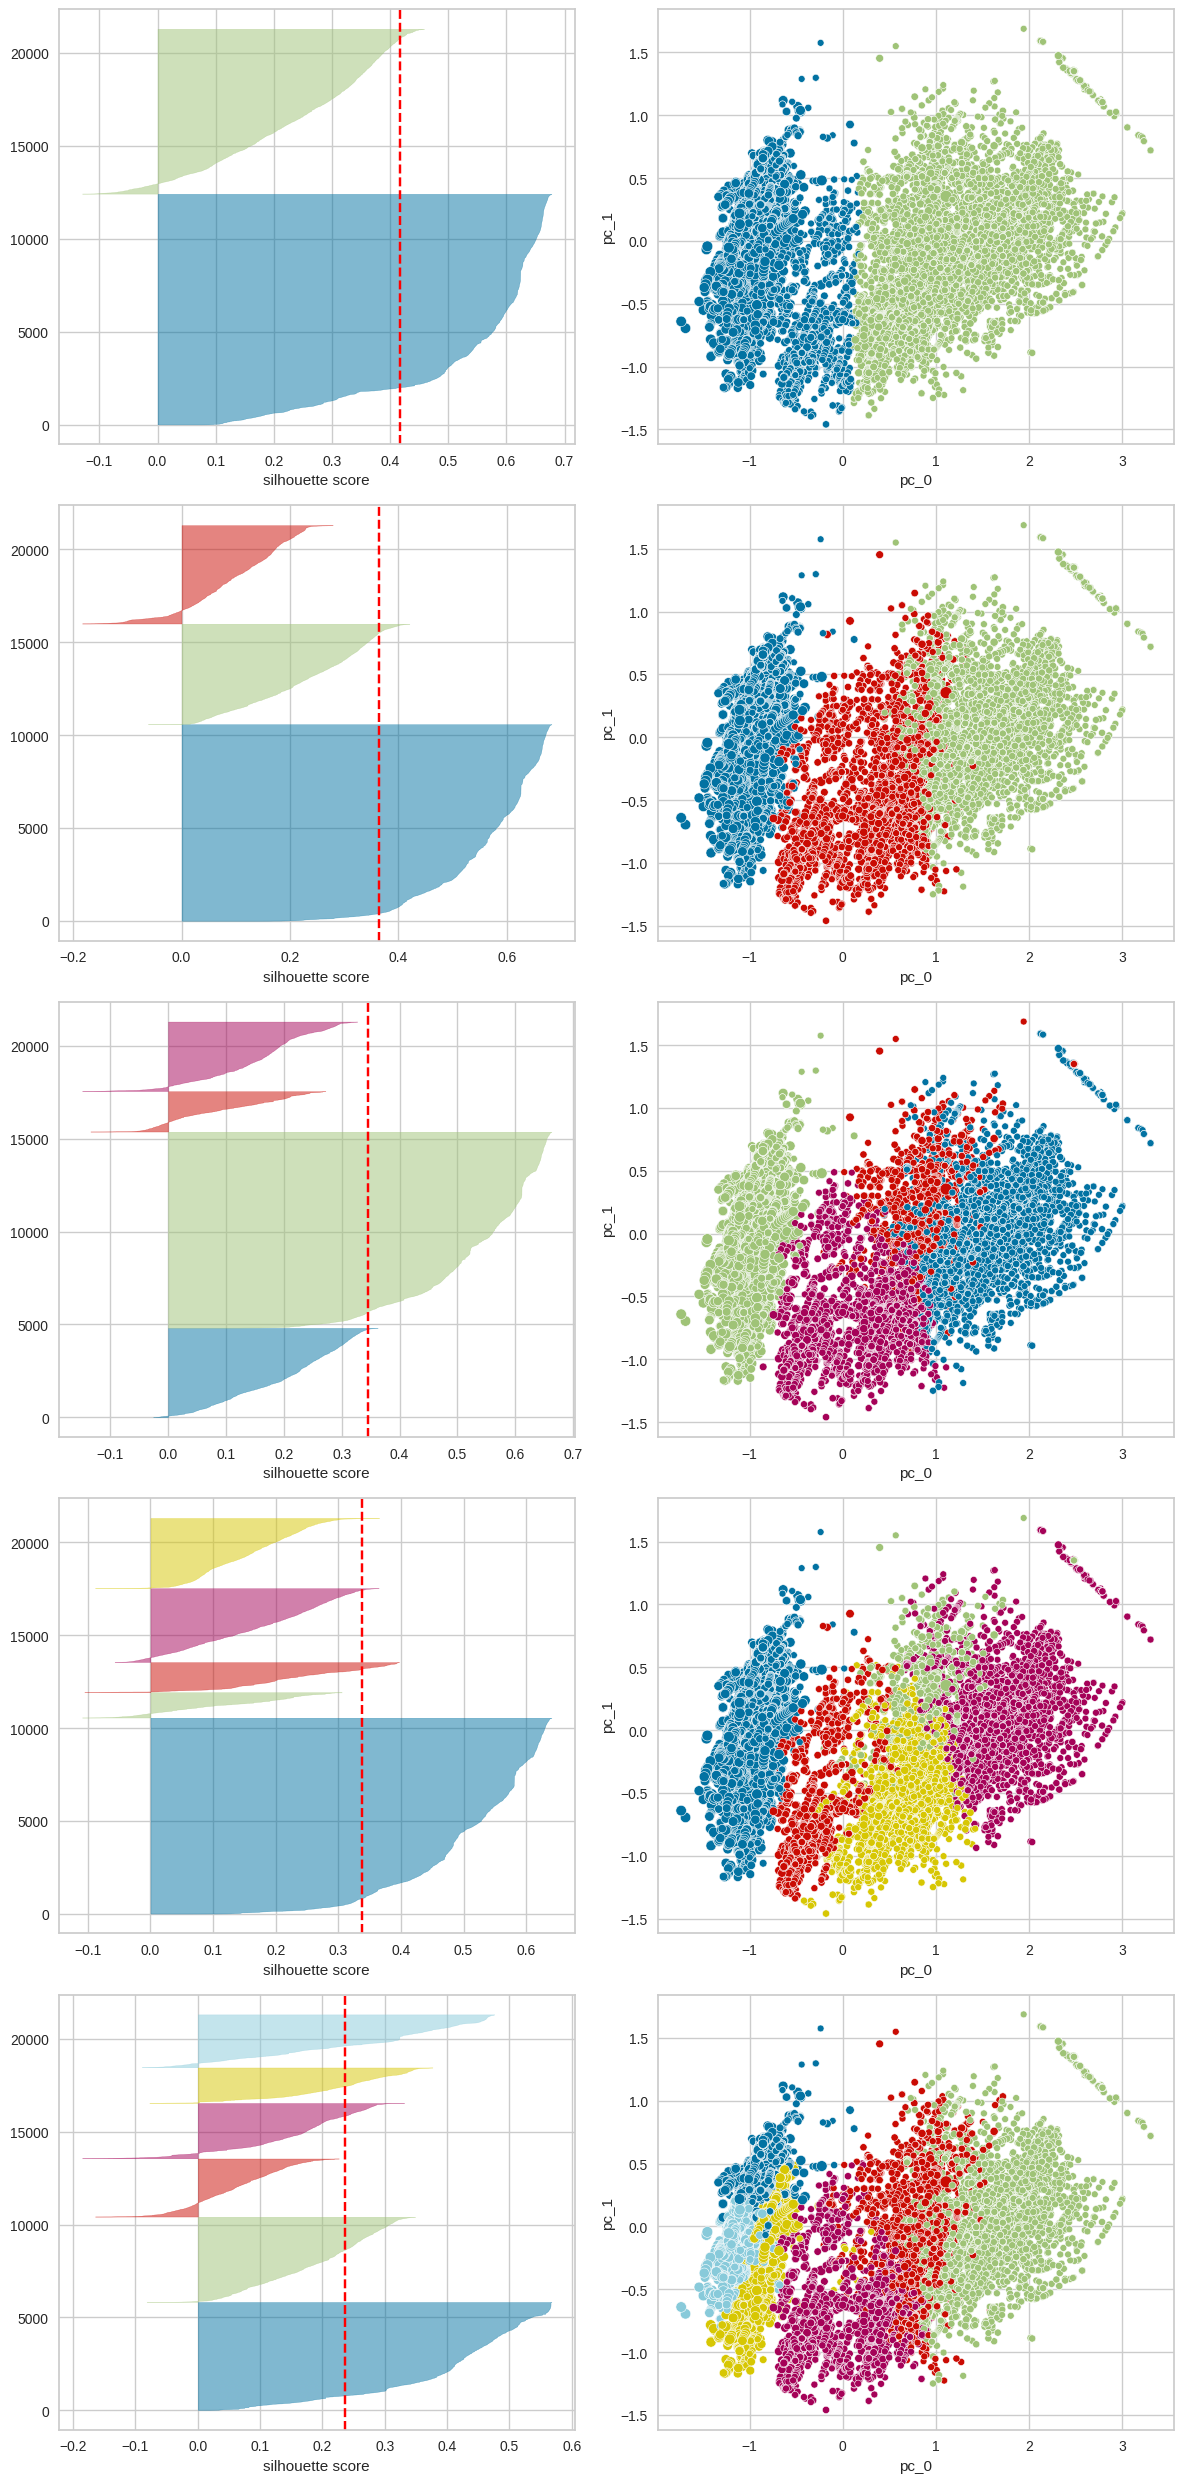

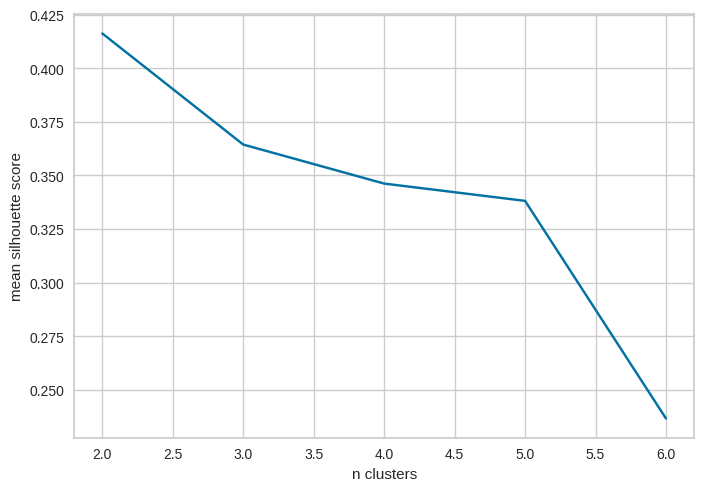

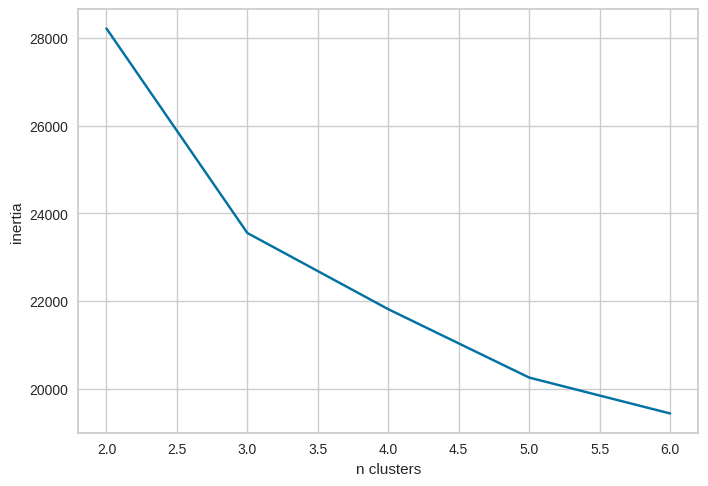

In [27]:
n_components = 15
cluster_number_analysis(df=df_pca, features=[f"pc_{i}" for i in range(n_components)], range_n_clusters=[2, 3, 4, 5, 6], features_to_plot=["pc_0", "pc_1"])

/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` ins

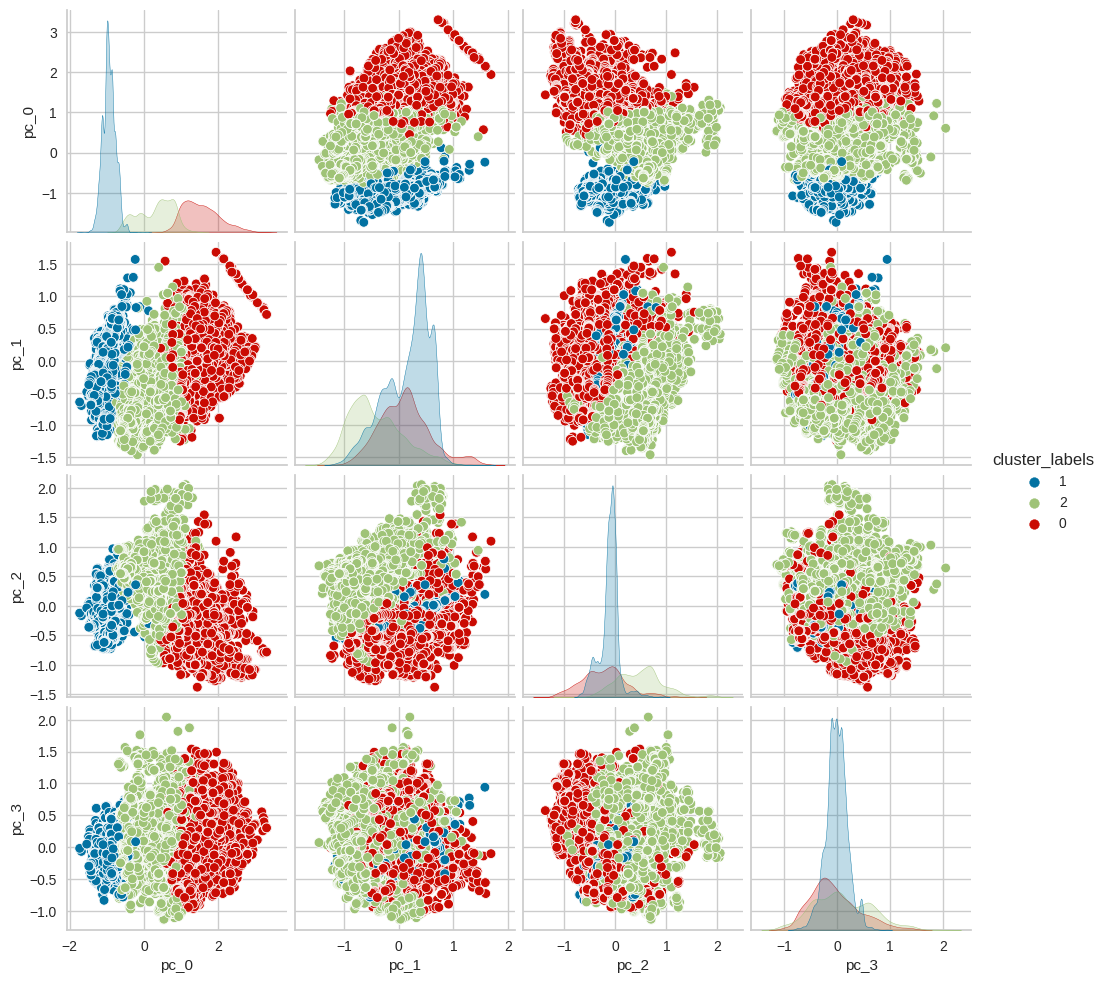

In [34]:
features = [f"pc_{i}" for i in range(15)]
clusterer = KMeans(n_clusters=3)
cluster_labels = clusterer.fit_predict(df_pca[features])

sns.pairplot(
    df_pca.assign(**{"cluster_labels": cluster_labels.astype(str)}),
    x_vars=[f"pc_{i}" for i in range(4)],
    y_vars=[f"pc_{i}" for i in range(4)],
    hue="cluster_labels",
)

/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` ins

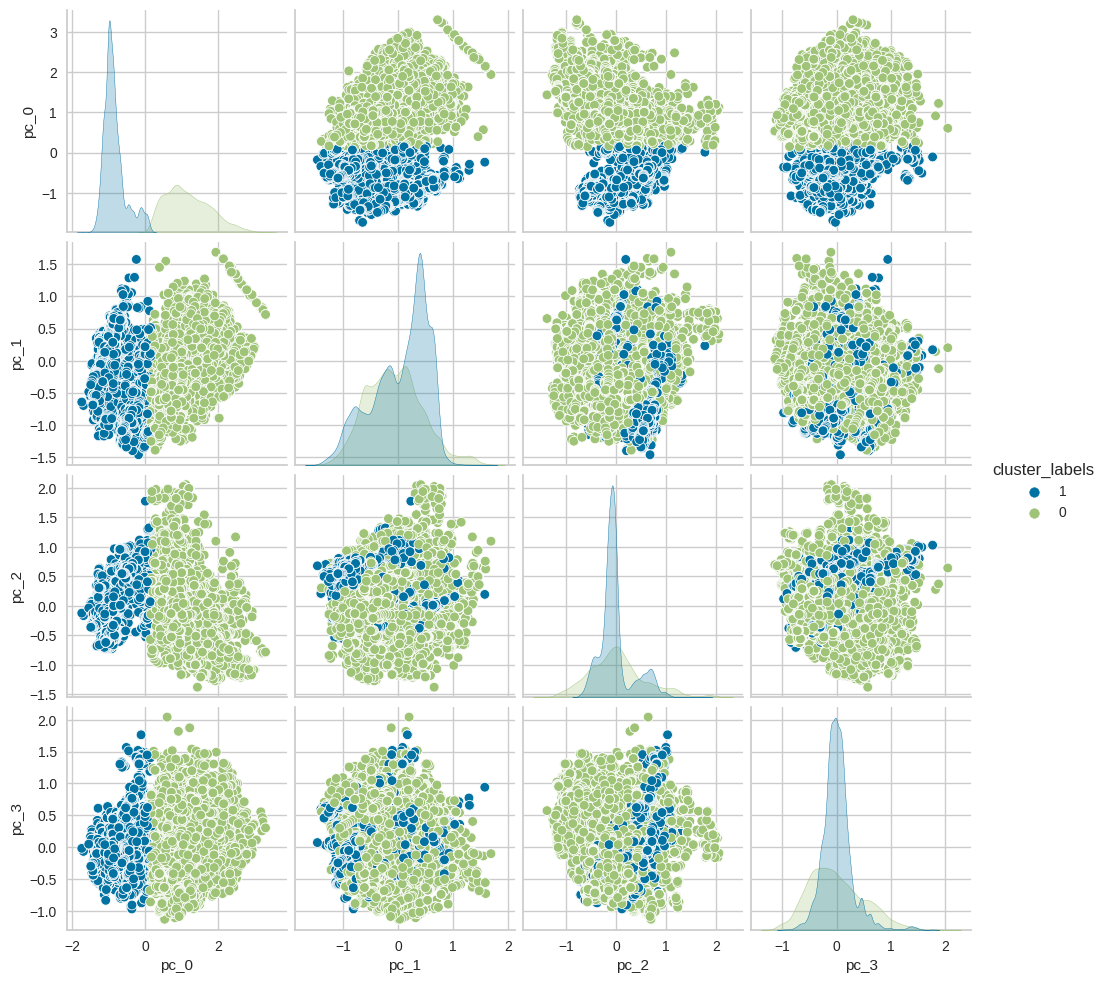

In [35]:
features = [f"pc_{i}" for i in range(15)]
clusterer = KMeans(n_clusters=2)
cluster_labels = clusterer.fit_predict(df_pca[features])

sns.pairplot(
    df_pca.assign(**{"cluster_labels": cluster_labels.astype(str)}),
    x_vars=[f"pc_{i}" for i in range(4)],
    y_vars=[f"pc_{i}" for i in range(4)],
    hue="cluster_labels",
)

/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/yparomau/.cache/pypoetry/virtualenvs/superconduct-tc-reg-45I6S9r8-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` ins

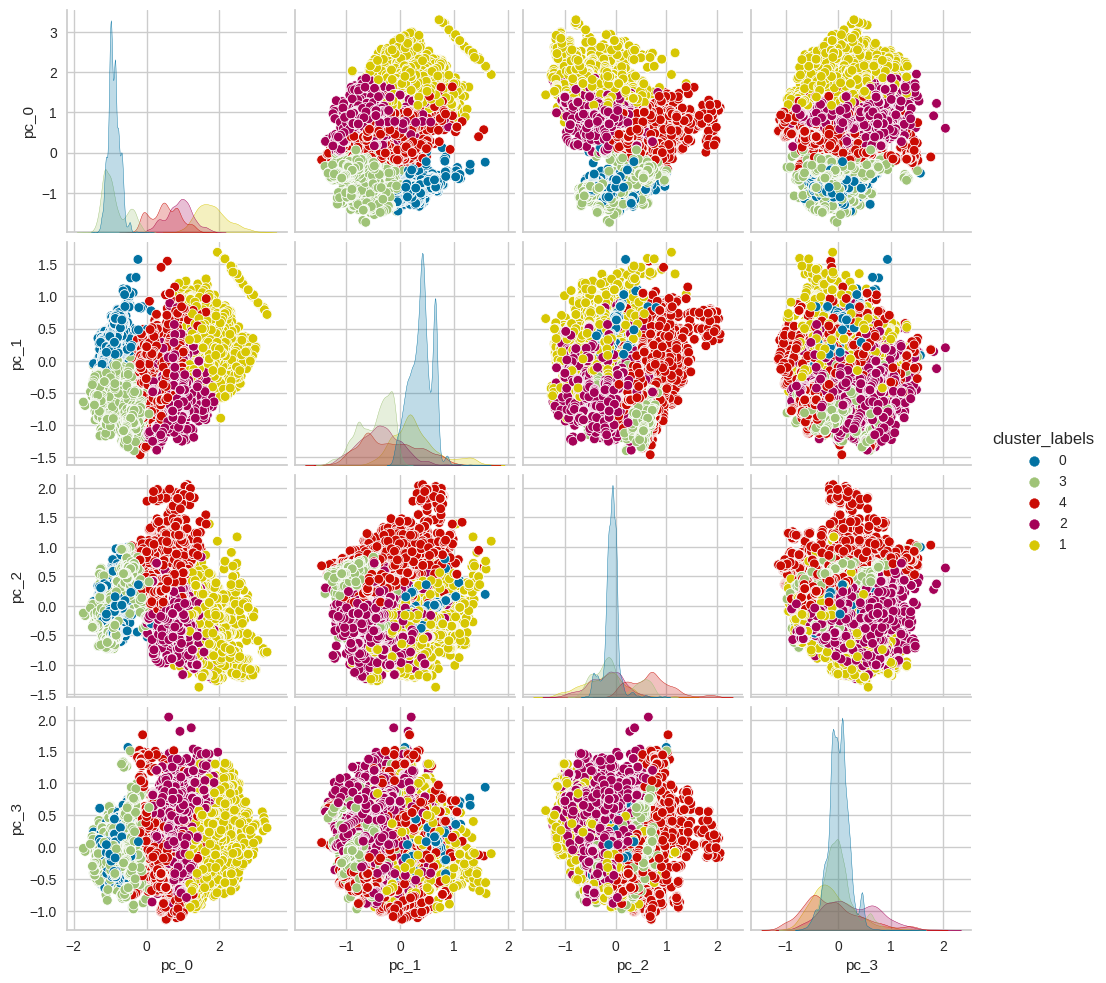

In [36]:
features = [f"pc_{i}" for i in range(15)]
clusterer = KMeans(n_clusters=5)
cluster_labels = clusterer.fit_predict(df_pca[features])

sns.pairplot(
    df_pca.assign(**{"cluster_labels": cluster_labels.astype(str)}),
    x_vars=[f"pc_{i}" for i in range(4)],
    y_vars=[f"pc_{i}" for i in range(4)],
    hue="cluster_labels",
)